In [1]:
import sys
sys.path.append('/home/lumargot/trachoma/src/py')

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # put -1 to not use any

In [2]:
import math
import pandas as pd
import numpy as np 

import torch

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
from evaluation import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import SimpleITK as sitk
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.decomposition import PCA
import numpy as np
from sklearn.linear_model import LinearRegression

import plotly.graph_objects as go
import numpy as np


In [28]:
def read_data(dataframe, mount_point):

  list_class = []
  list_files = []
  list_data = []
  for idx, row in dataframe.iterrows():
    seg_path = os.path.join(mount_point, row['seg'])
    npy = seg_path.replace('seg', 'segmentation_heights').replace('.nrrd', '.npy')
    if os.path.exists(npy):
      data = np.load(npy,allow_pickle=True).item()
      x_values = data['x_values']
      heights = data['heights']

      valid_indices = ~np.isnan(heights)
      heights = heights[valid_indices]
      x_values = x_values[valid_indices]

      xmin = np.min(x_values)
      xmax = np.max(x_values)

      new_x = np.linspace(xmin, xmax, num=400)
      new_y = np.interp(new_x, x_values, heights)
      list_data.append(new_y)

      list_class.append(row['class'])
      list_files.append(npy)

  all_heights = np.stack(list_data, axis=0)
  all_classes = np.array(list_class)

  return all_heights, all_classes, list_files

In [5]:
df_train = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg_train_train.csv')
df_val = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg_train_test.csv')
df_test = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg_test.csv')

seg_column='seg'
class_column='class'
mount_point='/CMF/data/lumargot/trachoma/PoPP_Data/mtss'

In [ ]:
# df_train = df_train.loc[df_train['new_label']!=-1]
# df_test = df_test.loc[df_test['new_label']!=-1]

In [35]:
g_train = df_train.groupby('class')
df_train = g_train.apply(lambda x: x.sample(g_train.size().min())).reset_index(drop=True).sample(frac=1).reset_index(drop=True)

all_heights_train, all_classes_train, _ = read_data(df_train, mount_point)
all_heights_test, all_classes_test, _ = read_data(df_test, mount_point)

/tmp/ipykernel_1177546/4147184499.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = g_train.apply(lambda x: x.sample(g_train.size().min())).reset_index(drop=True).sample(frac=1).reset_index(drop=True)


In [36]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix, avg:", np.trace(cm)/len(classes))
      plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto',vmin=0, vmax=1)
    else:
      print('Confusion matrix, without normalization')
      plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = .5 if normalize else np.sum(cm)/4
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

    return cm

In [ ]:
# def compute_heights(dataframe):
#   all_heights = []
#   all_classes = []
#   for idx, row in dataframe.iterrows():
#     seg_path = os.path.join(mount_point, row['seg'])
#     seg = torch.tensor(sitk.GetArrayFromImage(sitk.ReadImage(seg_path)).copy())
#     eyelid_seg = (seg == 3).float()

#     y_coords, x_coords = np.where(eyelid_seg > 0)
#     if len(y_coords) > 0:
#       min_y, max_y = np.min(y_coords), np.max(y_coords)
#       min_x, max_x = np.min(x_coords), np.max(x_coords)

#       eyelid_width = max_x - min_x + 1

#       heights = []
#       x_positions = np.linspace(min_x, max_x, num=min(400, eyelid_width)).astype(int)

#       heights = []

#       for i, x in enumerate(x_positions):
#           y_at_x = y_coords[x_coords == x]
#           if len(y_at_x) > 0:
#             h = np.max(y_at_x) - np.min(y_at_x) + 1
#             heights.append(h)
#           else:
#             heights.append(0)
#       heights = np.array(heights)
#       # heights = (heights - np.min(heights)) / (np.max(heights) - np.min(heights))
#       new_x = np.linspace(min_x, max_x, num=400)
#       new_y = np.interp(new_x, x_positions, heights)

#       all_heights.append(new_y)
#       all_classes.append(int(row['class']))
#   return all_heights, all_classes

train ~ 7min
val ~ 1min
test ~ 2min

In [9]:
# df_train = df_train.loc[df_train['class']!=0]
# df_test = df_test.loc[df_test['class']!=0]
# df_val = df_val.loc[df_val['class']!=0]

### Random Forest

In [37]:
clf = RandomForestClassifier(max_depth=None,
                             n_estimators=300,    # More trees
                             random_state=0,
                             class_weight='balanced'
                            #  class_weight={0:0.6, 1:1.51, 2:1.9},
                             )
scaler = StandardScaler()

In [38]:
X_train_scaled = scaler.fit_transform(all_heights_train)
X_test_scaled = scaler.transform(all_heights_test)

clf.fit(X_train_scaled, all_classes_train)
classes_predicted = clf.predict(X_test_scaled)

              precision    recall  f1-score   support

         0.0       0.61      0.42      0.50       191
         1.0       0.37      0.39      0.38       119
         2.0       0.24      0.40      0.30        77

    accuracy                           0.41       387
   macro avg       0.41      0.41      0.40       387
weighted avg       0.46      0.41      0.42       387

Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.4072130518080626


/tmp/ipykernel_1177546/331894928.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


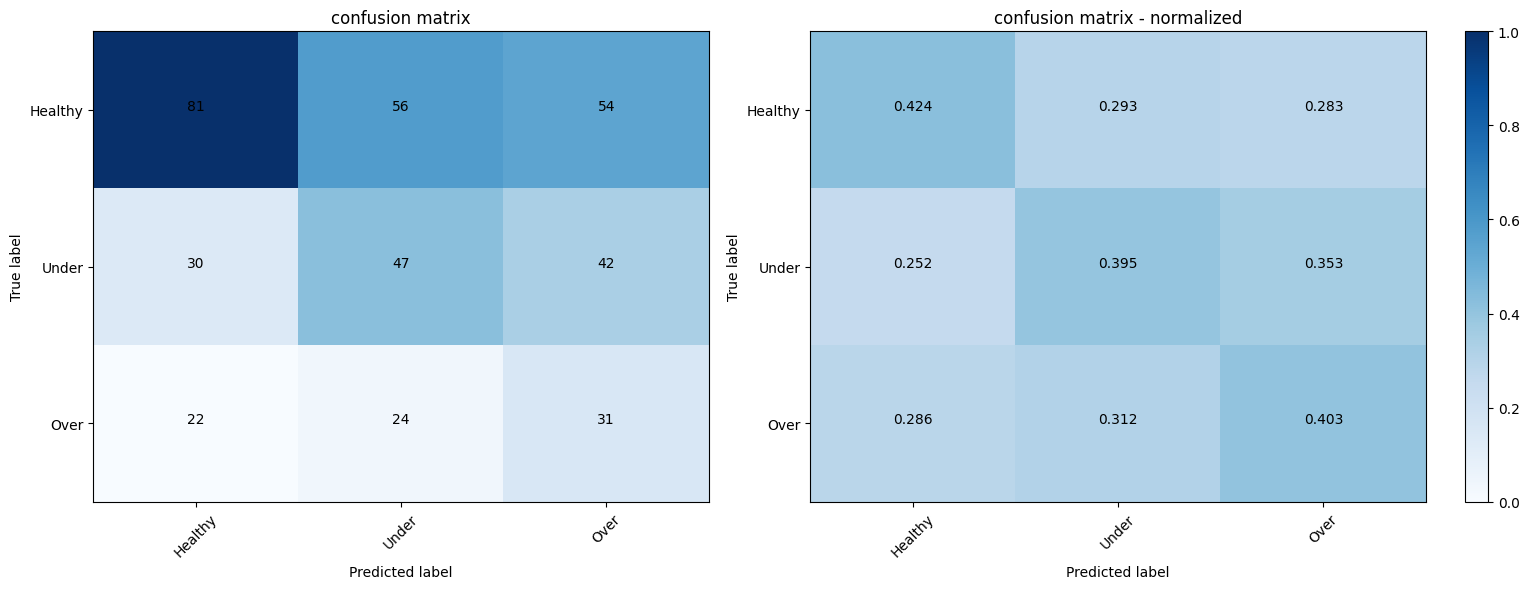

In [39]:
class_names = ['Healthy', 'Under', 'Over']

print(classification_report(all_classes_test, classes_predicted ))

fig = plt.figure(figsize=(16,6))
plt.subplot(121)
cnf_matrix = confusion_matrix(all_classes_test,classes_predicted )
plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')
plt.subplot(122)
cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')


### PCA + LR

In [40]:
X= all_heights_train
y = all_classes_train
temp_pca = PCA()
temp_pca.fit(scaler.fit_transform(X))

cumsum = np.cumsum(temp_pca.explained_variance_ratio_)
n_components = np.argmax(cumsum >= 0.95) + 1

print(f"Auto-selected {n_components} components (95% variance)")

# Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components, random_state=42)),
    ('classifier', LogisticRegression( max_iter=2000,  
                                      class_weight='balanced',
                                    # class_weight={0:0.6, 1:1.51, 2:1.9},
                                       solver='saga', random_state=42))
])

pipeline.fit(X, y)
pca = pipeline.named_steps['pca']
classifier = pipeline.named_steps['classifier']
scaler = pipeline.named_steps['scaler']


Auto-selected 13 components (95% variance)


              precision    recall  f1-score   support

         0.0       0.60      0.41      0.49       191
         1.0       0.43      0.49      0.45       119
         2.0       0.21      0.34      0.26        77

    accuracy                           0.42       387
   macro avg       0.41      0.41      0.40       387
weighted avg       0.47      0.42      0.43       387

Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.4111447529987721


/tmp/ipykernel_1177546/2795014234.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


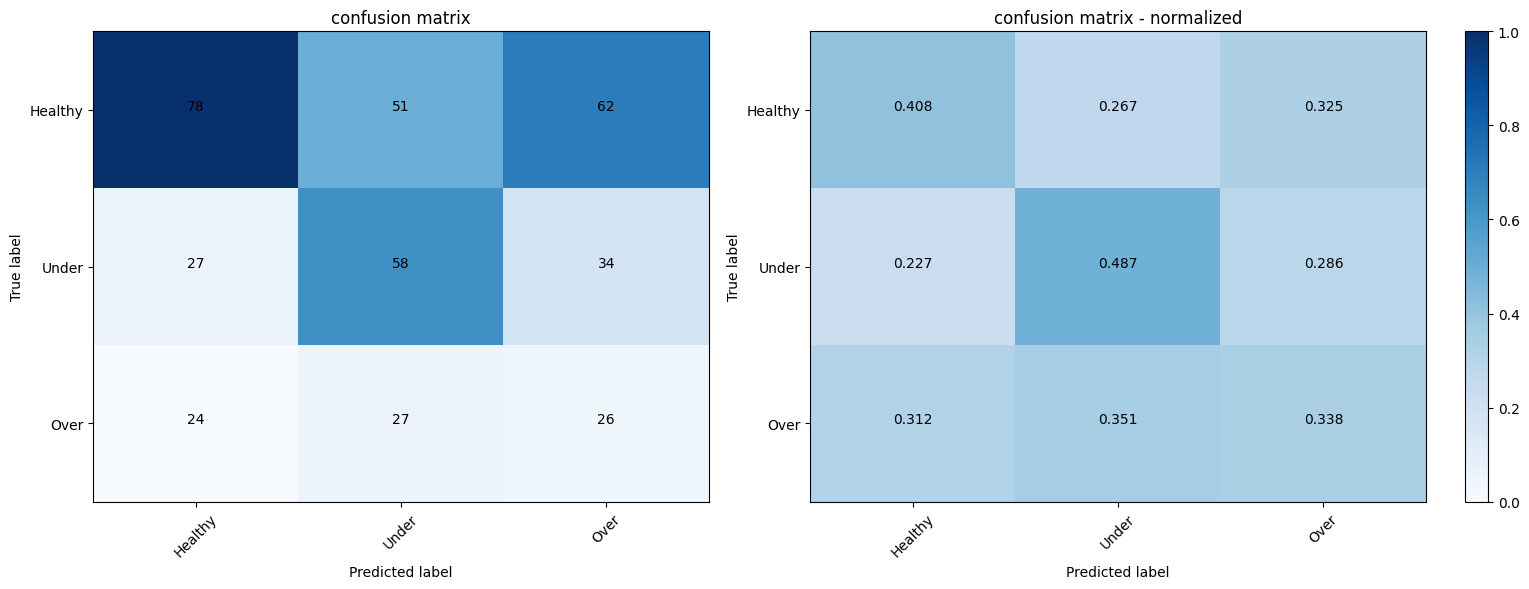

In [41]:
pred = pipeline.predict(all_heights_test)
print(classification_report(all_classes_test, pred ))
class_names = ['Healthy', 'Under', 'Over']

fig = plt.figure(figsize=(16,6))
plt.subplot(121)
cnf_matrix = confusion_matrix(all_classes_test,pred )
plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')
plt.subplot(122)
cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')

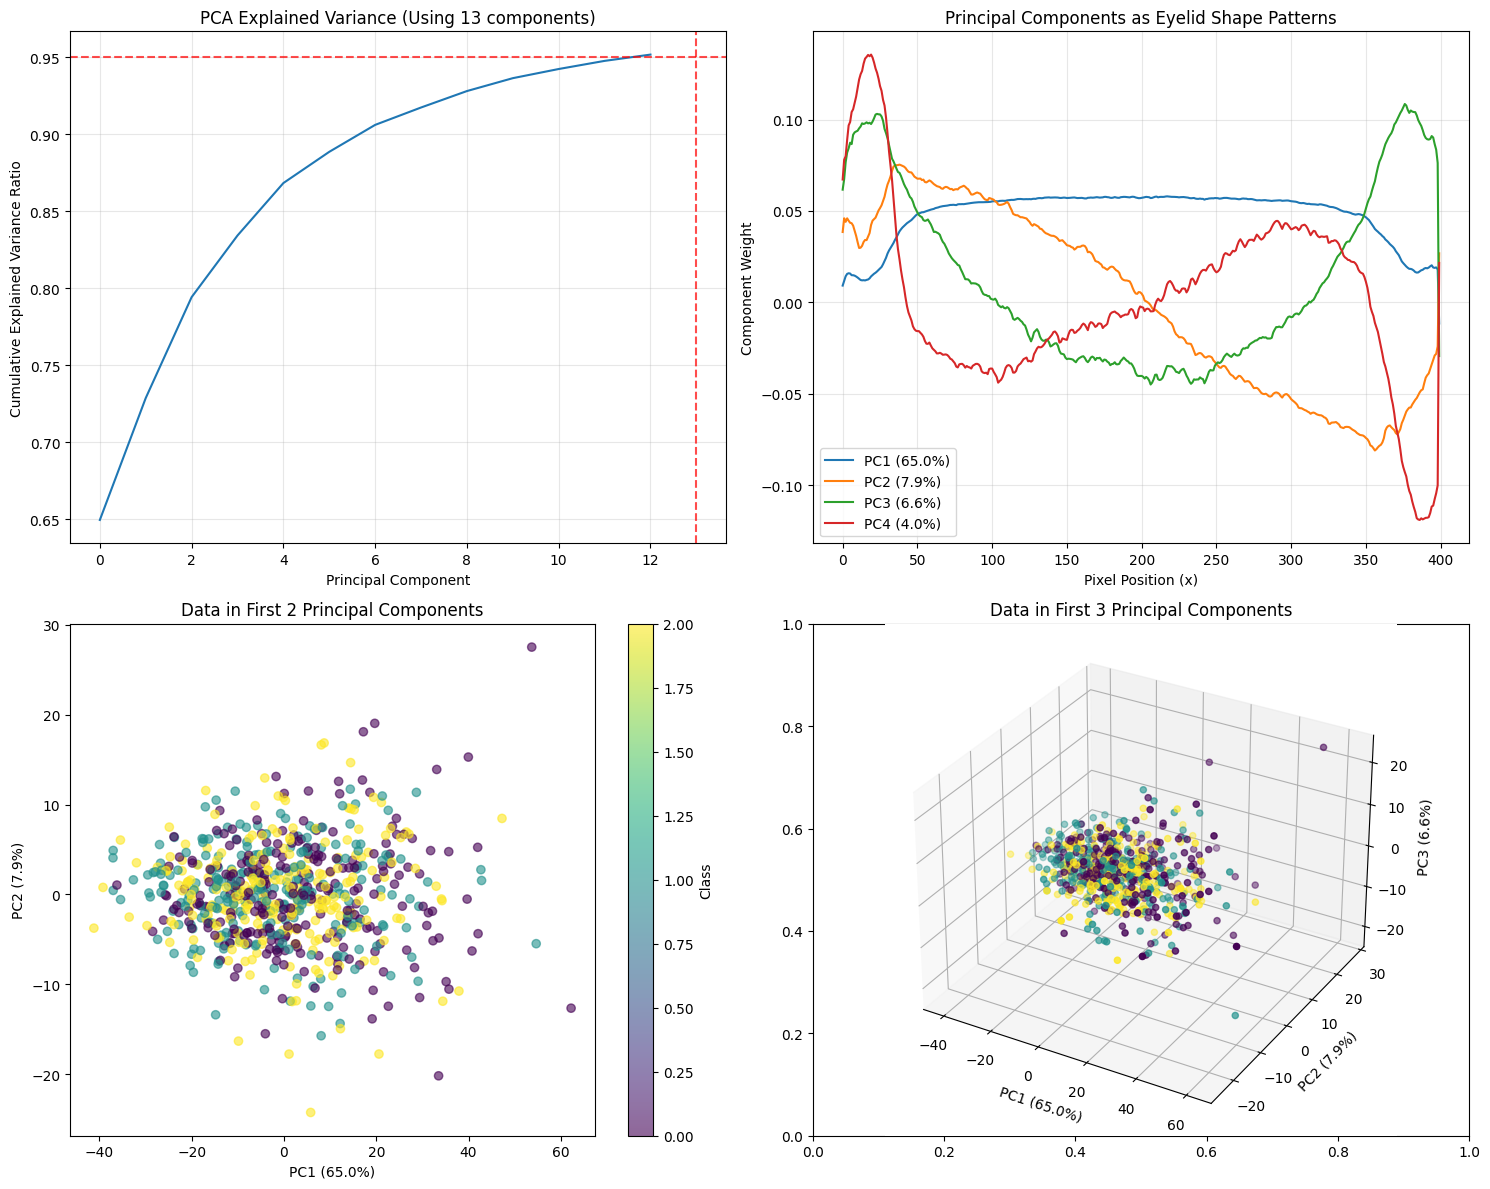

In [42]:
# Transform data
X_scaled = scaler.transform(X)
X_pca = pca.transform(X_scaled)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Explained variance ratio
axes[0, 0].plot(np.cumsum(pca.explained_variance_ratio_))
axes[0, 0].axhline(y=0.95, color='r', linestyle='--', alpha=0.7)
axes[0, 0].axvline(x=n_components, color='r', linestyle='--', alpha=0.7)
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Cumulative Explained Variance Ratio')
axes[0, 0].set_title(f'PCA Explained Variance (Using {n_components} components)')
axes[0, 0].grid(True, alpha=0.3)

# 2. First few principal components as eyelid shapes
n_shapes = min(4, n_components)
for i in range(n_shapes):
    component = pca.components_[i]
    axes[0, 1].plot(component, label=f'PC{i+1} ({pca.explained_variance_ratio_[i]:.1%})')

axes[0, 1].set_xlabel('Pixel Position (x)')
axes[0, 1].set_ylabel('Component Weight')
axes[0, 1].set_title('Principal Components as Eyelid Shape Patterns')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. 2D PCA scatter plot
scatter = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.6)
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1, 0].set_title('Data in First 2 Principal Components')
plt.colorbar(scatter, ax=axes[1, 0], label='Class')

# 4. 3D plot if we have enough components
if n_components >= 3:
    ax = fig.add_subplot(224, projection='3d')
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})')
    ax.set_title('Data in First 3 Principal Components')
else:
    # Show component weights distribution
    axes[1, 1].hist(X_pca[:, 0], bins=30, alpha=0.7, label='PC1')
    if n_components >= 2:
        axes[1, 1].hist(X_pca[:, 1], bins=30, alpha=0.7, label='PC2')
    axes[1, 1].set_xlabel('Component Score')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of PC Scores')
    axes[1, 1].legend()

plt.tight_layout()
plt.show()


### LDA (Linear Discriminant Analysis)

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, validation_curve
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold


In [44]:
X = all_heights_train
y = all_classes_train

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])


pipeline.fit(X, y)
lda = pipeline.named_steps['lda']
scaler = pipeline.named_steps['scaler']

LDA created 2 discriminant functions for 3 classes
Explained variance ratio by discriminant function:
LD1: 0.642 (64.2%)
LD2: 0.358 (35.8%)


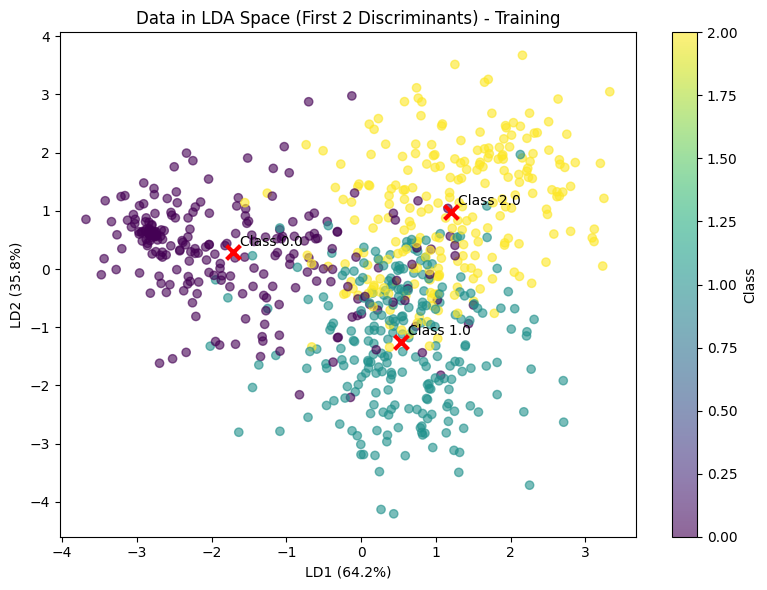


Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.26      0.36       191
         1.0       0.30      0.41      0.35       119
         2.0       0.22      0.39      0.28        77

    accuracy                           0.33       387
   macro avg       0.36      0.35      0.33       387
weighted avg       0.42      0.33      0.34       387

Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.35438506673492814

LDA Insights:
- Number of discriminant functions: 2
- Most important discriminant explains 64.2% of variance
- First two discriminants explain 100.0% of total variance

Top 10 most discriminative pixel positions (for LD1): [218 182 137 226 161 163 230 227 162 229]

Class separability metrics:
- Prior probabilities: {0.0: 0.33608815426997246, 1.0: 0.3319559228650138, 2.0: 0.3319559228650138}


/tmp/ipykernel_1177546/851707000.py:46: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


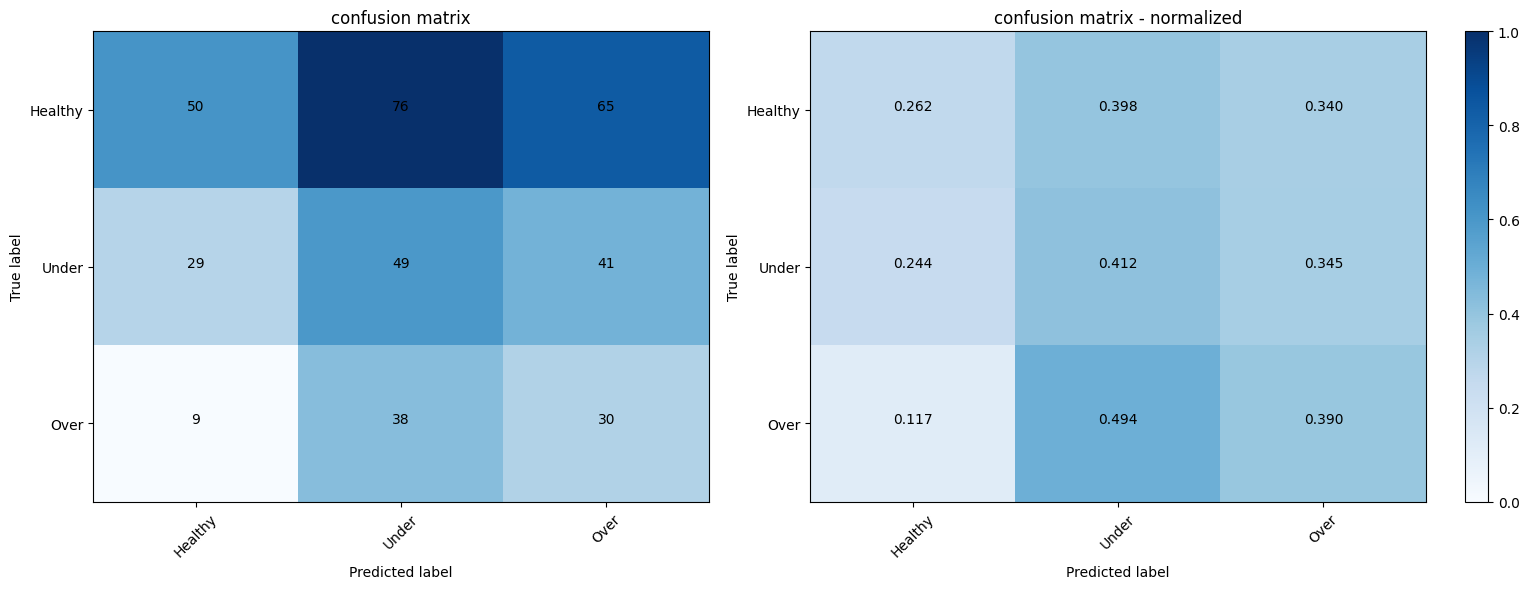

In [45]:
pred = pipeline.predict(all_heights_test)
X_scaled = scaler.transform(X)
X_lda = lda.transform(X_scaled)

n_components = X_lda.shape[1]
print(f"LDA created {n_components} discriminant functions for {len(np.unique(y))} classes")

# Print explained variance ratio for each discriminant function
explained_variance_ratio = lda.explained_variance_ratio_
print("Explained variance ratio by discriminant function:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"LD{i+1}: {ratio:.3f} ({ratio*100:.1f}%)")

# Create comprehensive visualization
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# 3. 2D LDA scatter plot (if we have at least 2 discriminants)
scatter = axes.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='viridis', alpha=0.6)
axes.set_xlabel(f'LD1 ({explained_variance_ratio[0]:.1%})')
axes.set_ylabel(f'LD2 ({explained_variance_ratio[1]:.1%})')
axes.set_title('Data in LDA Space (First 2 Discriminants) - Training')
plt.colorbar(scatter, ax=axes, label='Class')

# Add class centroids
for class_label in np.unique(y):
    class_mask = y == class_label
    centroid_x = np.mean(X_lda[class_mask, 0])
    centroid_y = np.mean(X_lda[class_mask, 1])
    axes.scatter(centroid_x, centroid_y, c='red', s=100, marker='x', linewidth=3)
    axes.annotate(f'Class {class_label}', (centroid_x, centroid_y), 
                        xytext=(5, 5), textcoords='offset points')

# plt.axis([-30, 30, -40, 40])
plt.tight_layout()
plt.show()

# Additional analysis: Confusion matrix and classification report

print("\nClassification Report:")
print(classification_report(all_classes_test, pred))

fig = plt.figure(figsize=(16,6))
plt.subplot(121)
cnf_matrix = confusion_matrix(all_classes_test,pred )
plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')
plt.subplot(122)
cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')


# Print some insights about the discriminant functions
print("\nLDA Insights:")
print(f"- Number of discriminant functions: {n_components}")
print(f"- Most important discriminant explains {explained_variance_ratio[0]*100:.1f}% of variance")

if n_components >= 2:
    print(f"- First two discriminants explain {sum(explained_variance_ratio[:2])*100:.1f}% of total variance")

# Show which pixels are most important for discrimination
most_important_pixels = np.argsort(np.abs(lda.scalings_[:, 0]))[-10:]
print(f"\nTop 10 most discriminative pixel positions (for LD1): {most_important_pixels}")

# Calculate between-class to within-class scatter ratio (higher is better separation)
print(f"\nClass separability metrics:")
print(f"- Prior probabilities: {dict(zip(lda.classes_, lda.priors_))}")

### Only Logistic Regression

In [46]:
X = all_heights_train
y = all_classes_train
# lr_model = LogisticRegression(max_iter=2000, random_state=42)
# lr_model = LogisticRegression(max_iter=2000, penalty='l1', solver='saga',random_state=42)
lr_model = LogisticRegression(max_iter=2000, penalty='l2',C=10.0, random_state=42)


pipeline = Pipeline([('scaler', StandardScaler()),
                     ('classifier', lr_model)
                     ])

pipeline.fit(X, y)
pred = pipeline.predict(all_heights_test)

              precision    recall  f1-score   support

         0.0       0.54      0.30      0.39       191
         1.0       0.34      0.45      0.39       119
         2.0       0.19      0.30      0.23        77

    accuracy                           0.35       387
   macro avg       0.36      0.35      0.34       387
weighted avg       0.41      0.35      0.36       387

Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.3520492442574364


/tmp/ipykernel_1177546/3858442903.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


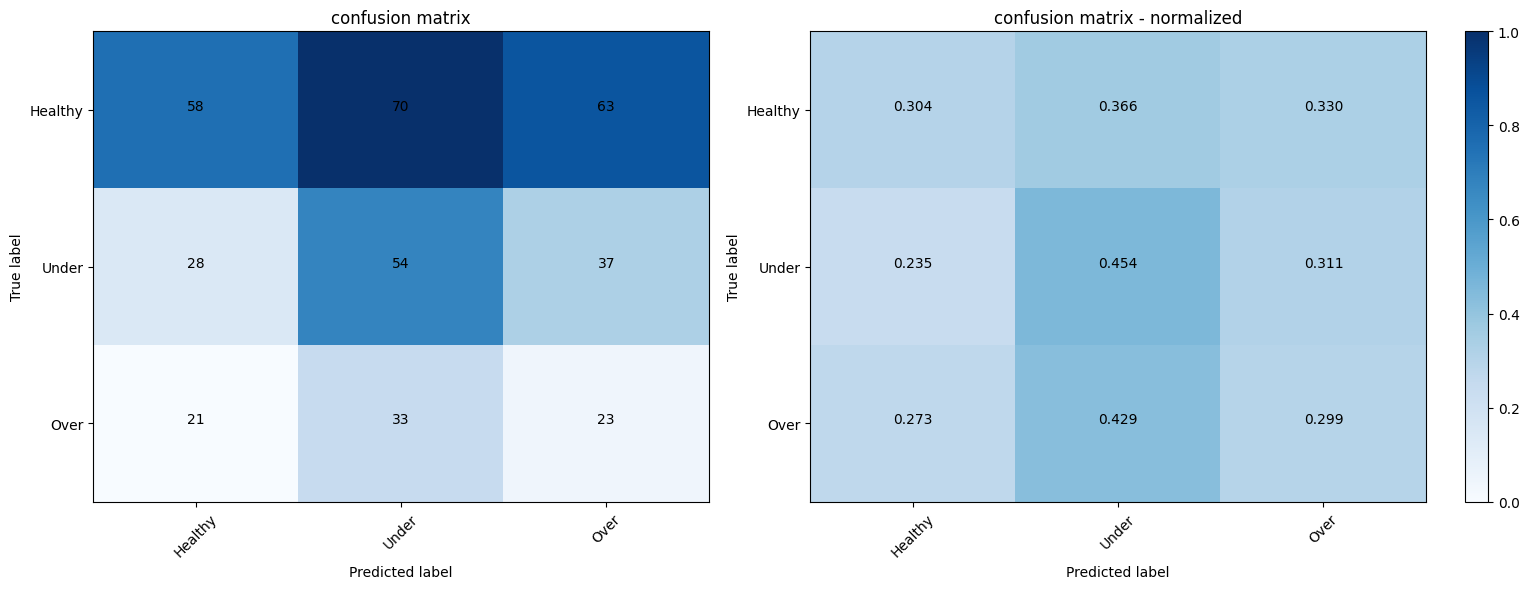

In [47]:
print(classification_report(all_classes_test, pred))

fig = plt.figure(figsize=(16,6))
plt.subplot(121)
cnf_matrix = confusion_matrix(all_classes_test,pred )
plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')
plt.subplot(122)
cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')


### Gaussian Naive Bayes

In [48]:
from sklearn.naive_bayes import GaussianNB

In [49]:
X = all_heights_train
y = all_classes_train

gnb = GaussianNB()
gnb.fit(X, y)
pred = gnb.predict(all_heights_test)

              precision    recall  f1-score   support

         0.0       0.56      0.34      0.42       191
         1.0       0.41      0.46      0.43       119
         2.0       0.22      0.39      0.28        77

    accuracy                           0.39       387
   macro avg       0.39      0.40      0.38       387
weighted avg       0.44      0.39      0.40       387

Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.39562459919712767


/tmp/ipykernel_1177546/3858442903.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


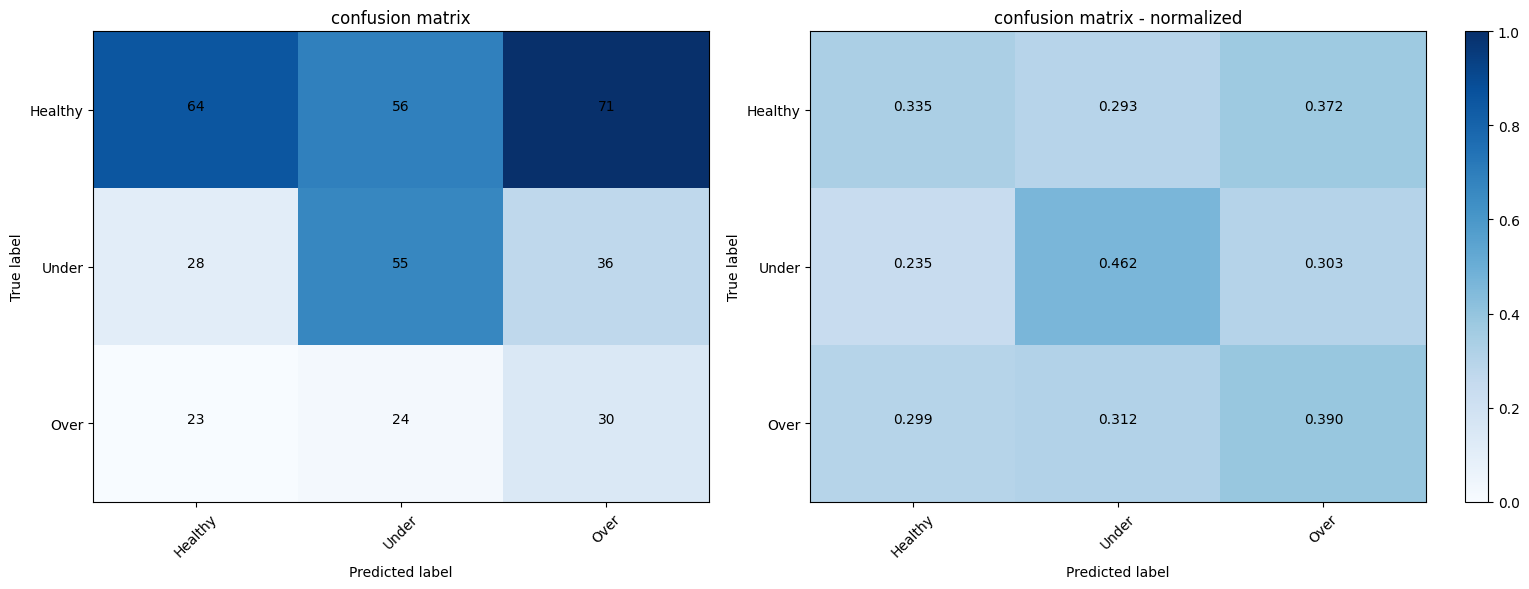

In [50]:
print(classification_report(all_classes_test, pred))

fig = plt.figure(figsize=(16,6))
plt.subplot(121)
cnf_matrix = confusion_matrix(all_classes_test,pred )
plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')
plt.subplot(122)
cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')
